In [1]:
import os
import cv2
from time import time
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random
from dask import delayed

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

In [3]:
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature

In [83]:
from logistic import logistic_fit, logistic, logistic_prob

In [4]:
import dill

In [61]:
dill.dump_session('01_06_env.db')

In [46]:
t_start = time()
dill.load_session('01_05_env.db')
time() - t_start

75290.20285177231

# Helper Methods

In [115]:
def proportion_b(facenames, n):
    count = 0
    for i in range(n):
        if int(facenames[i].split('_')[3]) == 0:
            count += 1
    return count / n

In [14]:
@delayed
def extract_feature_image(img, feature_type, feature_coord=None):
    """Extract the haar feature for the current image"""
    img = cv2.resize(img, (36,36))
    ii = integral_image(img)
    return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                             feature_type=feature_type,
                             feature_coord=feature_coord)

In [116]:
for f in [face_filenames0, face_filenames25, face_filenames50, face_filenames75, face_filenames100]:
    print(proportion_b(f, n))

1.0
0.7502487562189055
0.5
0.24975124378109453
0.0


In [72]:
def getimgs(facefiles, nonfaces, n):
    faces = []
    for i in range(n):
        faces.append(cv2.imread(facefiles[i], cv2.IMREAD_GRAYSCALE))
    return faces + nonfaces[:n]

In [71]:
def getx(facefiles, n):
    ims = getimgs(facefiles, n)
    X = delayed(extract_feature_image(img, feature_types) for img in ims)
    return np.array(X.compute(scheduler='threads'))

In [150]:
def getx2(facefiles, n, nonfaces, feature_types, feature_coords):
    ims = getimgs(facefiles, nonfaces, n)
    X = delayed(extract_feature_image(img, feature_types, feature_coords) for img in ims)
    return np.array(X.compute(scheduler='threads'))

In [77]:
n, len(nonfaces)

(4020, 4020)

# Feature selection

In [5]:
test_face_names = sorted(glob(os.path.join('data/tests', '*.jpg')))
n_test = len(test_face_names)

In [6]:
b_inds = []
w_inds = []
for i in range(len(test_face_names)):
    if int(test_face_names[i].split('_')[2]) is 0: # race is white
        w_inds.append(i)
    else:
        b_inds.append(i)

In [7]:
test_nonface_names = sorted(glob(os.path.join('data/testing_nonfaces', '*.jpg')))
n_nonfaces_test = len(test_nonface_names)

In [8]:
faces_t = []
for i in range(n_test):
    faces_t.append(cv2.imread(test_face_names[i], cv2.IMREAD_GRAYSCALE))

In [9]:
nonfaces_t = []
for i in range(n_test):
    # Read a random nonface file
    j = random.randint(0, n_nonfaces_test - 1)
    nonface = cv2.imread(test_nonface_names[j], cv2.IMREAD_GRAYSCALE)
    
    wsize = random.randint(36, min(nonface.shape[0], nonface.shape[1]))
    row = random.randint(0, nonface.shape[0]-wsize)
    col = random.randint(0, nonface.shape[1]-wsize)
    crop = nonface[row:row+wsize, col:col+wsize]

    # Resize to be the right size
    crop = cv2.resize(crop, (200, 200))
    nonfaces_t.append(crop)

In [10]:
images_t = faces_t + nonfaces_t
len(images_t)

600

In [11]:
feature_types = ['type-2-x', 'type-2-y', 'type-3-x', 'type-3-y']

In [16]:
t_start = time()
Xf_t = delayed(extract_feature_image(img, feature_types) for img in images_t)
Xf_t = np.array(Xf_t.compute(scheduler='threads'))
time() - t_start

11501.80655002594

In [18]:
yf_t = np.array([1]*len(faces_t) + [0]*len(nonfaces_t))

In [127]:
# Train a random forest classifier and assess its performance
clf = RandomForestClassifier(n_estimators=1000, max_depth=None,
                             n_jobs=-1, random_state=0)
t_start = time()
clf.fit(Xf_t, yf_t)
time() - t_start

125.4239821434021

In [22]:
feature_coord, feature_type = \
    haar_like_feature_coord(width=36, height=36,
                            feature_type=feature_types)

In [129]:
idx_sorted = np.argsort(clf.feature_importances_)[::-1]

In [130]:
for i in range(1500):
    if len(feature_coord[idx_sorted[i]]) > 2:
        print(i)

1250
1325
1341
1403
1448


Text(0.5, 0.98, 'The most important features')

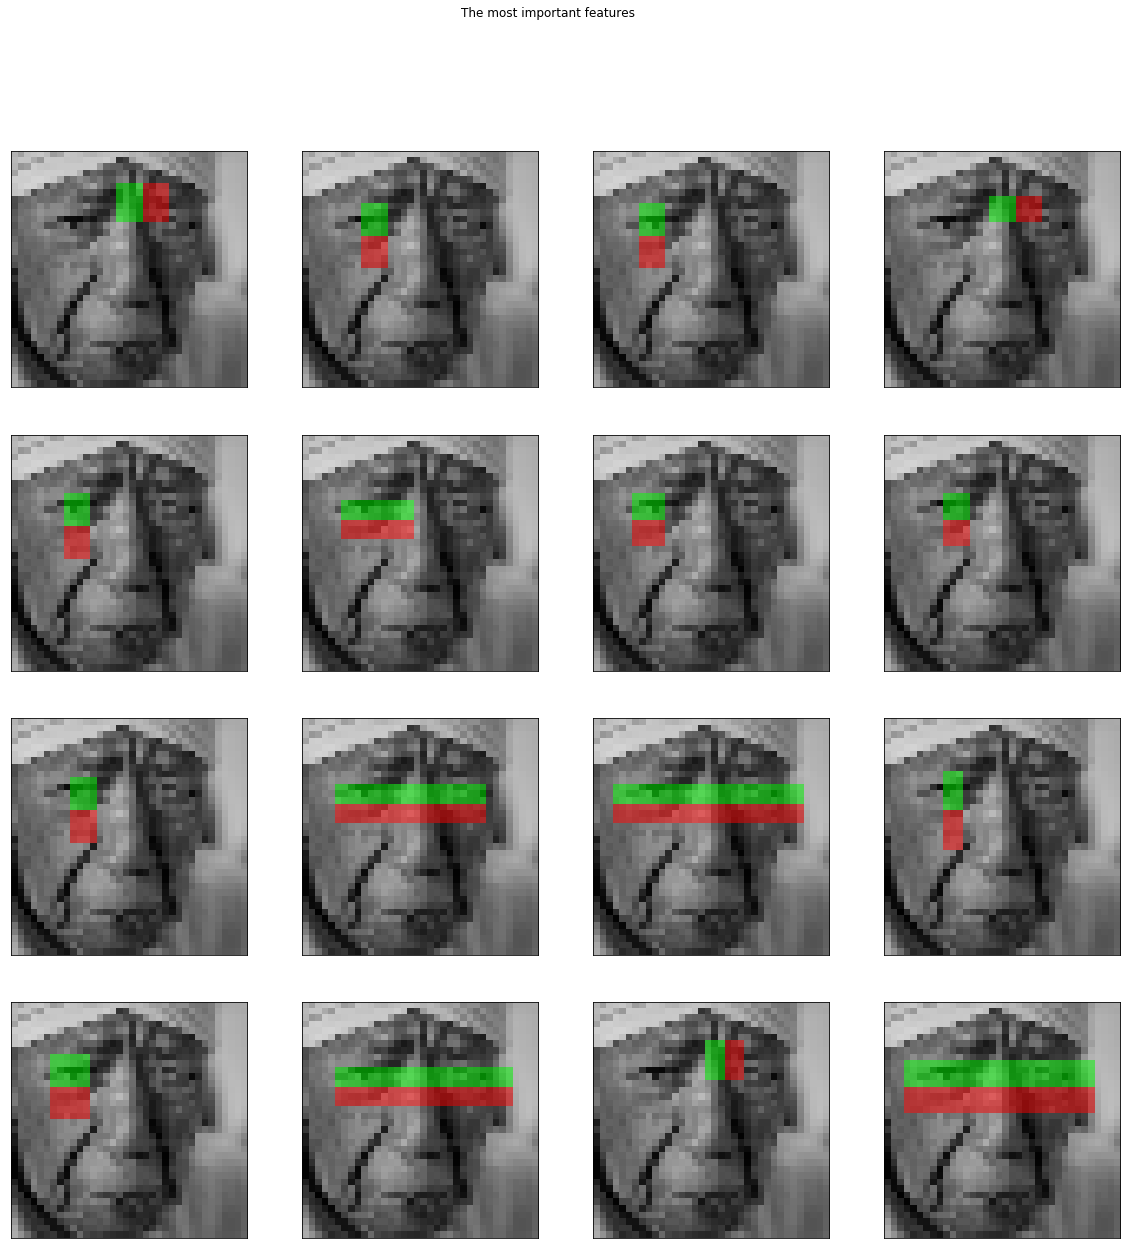

In [132]:
fig, axes = plt.subplots(4,4, figsize=(20,20))
for idx, ax in enumerate(axes.ravel()):
    image = cv2.resize(images_t[0], (36,36))
    image = draw_haar_like_feature(image, 0, 0, 36, 36,
                                   [feature_coord[idx_sorted[idx]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle('The most important features')

Text(0.5, 0.98, 'The most important features')

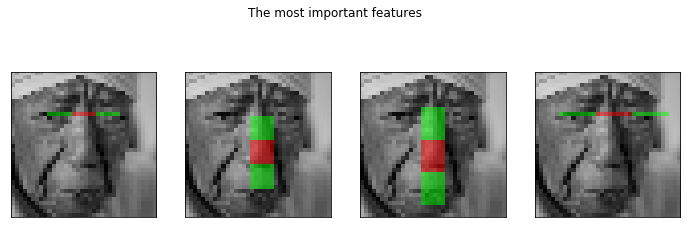

In [142]:
fig, axes = plt.subplots(1,4, figsize=(12,4))
idxs = [1250,1325,1341,1403,1448]
for idx, ax in enumerate(axes.ravel()):
    image = cv2.resize(images_t[0], (36,36))
    image = draw_haar_like_feature(image, 0, 0, 36, 36,
                                   [feature_coord[idx_sorted[idxs[idx]]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle('The most important features')

In [143]:
cdf_feature_importances = np.cumsum(clf.feature_importances_[idx_sorted])
cdf_feature_importances /= np.max(cdf_feature_importances)
sig_feature_count = np.count_nonzero(cdf_feature_importances < 0.7)
sig_feature_percent = round(sig_feature_count /
                            len(cdf_feature_importances) * 100, 1)
print(('{} features, or {}%, account for 70% of branch points in the '
       'random forest.').format(sig_feature_count, sig_feature_percent))

967 features, or 0.1%, account for 70% of branch points in the random forest.


In [48]:
ys = [i/200 for i in range(0,200)]
xs = []
for i in range(len(ys)):
    sig_feature_count = np.count_nonzero(cdf_feature_importances < ys[i])
    xs.append(sig_feature_count)

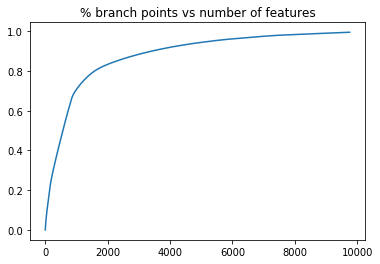

In [51]:
plt.plot(xs, ys)
plt.title("% branch points vs number of features")
plt.show()

In [56]:
np.count_nonzero(cdf_feature_importances < .82)

1807

In [57]:
n_features = 1800

In [58]:
feature_coord_sel = feature_coord[idx_sorted[:n_features]]
feature_type_sel = feature_type[idx_sorted[:n_features]]

In [59]:
n_features2 = 900

In [60]:
feature_coord_sel2 = feature_coord[idx_sorted[:n_features2]]
feature_type_sel2 = feature_type[idx_sorted[:n_features2]]

In [151]:
Xt_900 = getx2(test_face_names, 300, nonfaces_t, feature_type_sel2, feature_coord_sel2)

# Getting data

In [62]:
face_filenames0 = sorted(glob(os.path.join('data/train_0', '*.jpg')))
num_face_filenames0 = len(face_filenames0)
num_face_filenames0

4020

In [63]:
face_filenames25 = sorted(glob(os.path.join('data/train_25', '*.jpg')))
num_face_filenames25 = len(face_filenames25)
num_face_filenames25

4020

In [64]:
face_filenames50 = sorted(glob(os.path.join('data/train_50', '*.jpg')))
num_face_filenames50 = len(face_filenames50)
num_face_filenames50

4020

In [65]:
face_filenames75 = sorted(glob(os.path.join('data/train_75', '*.jpg')))
num_face_filenames75 = len(face_filenames75)
num_face_filenames75

4020

In [66]:
face_filenames100 = sorted(glob(os.path.join('data/train_100', '*.jpg')))
num_face_filenames100 = len(face_filenames100)
num_face_filenames100

4020

In [33]:
count = 0
for f in face_filenames0:
    if int(f.split('_')[3]) is 0: # race is white
        count += 1
count

4020

In [67]:
nonface_filenames = sorted(glob(os.path.join('data/training_nonfaces', '*.jpg')))
num_nonface_filenames = len(nonface_filenames)
num_nonface_filenames

250

# Classification

In [154]:
def getacc(predicted, actual):
    preds = []
    for p in predicted:
        if p >= 0.5:
            preds.append(1)
        else:
            preds.append(0)
    return 1 - sum(abs(preds-actual))/len(preds)

In [205]:
def getscore(X, y, params):
    predicted = logistic_prob(X, params)
    return getacc(predicted, y)

In [69]:
n = 4020

In [70]:
nonfaces = []
for i in range(n):
    # Read a random nonface file
    j = random.randint(0, num_nonface_filenames - 1)
    nonface = cv2.imread(nonface_filenames[j], cv2.IMREAD_GRAYSCALE)
    
    wsize = random.randint(50, min(nonface.shape[0], nonface.shape[1]))
    row = random.randint(0, nonface.shape[0]-wsize)
    col = random.randint(0, nonface.shape[1]-wsize)
    crop = nonface[row:row+wsize, col:col+wsize]

    # Resize to be the right size
    crop = cv2.resize(crop, (200, 200))
    nonfaces.append(crop)

In [80]:
t_start = time()
X0 = getx2(face_filenames0, n, feature_type_sel2, feature_coord_sel2)
time() - t_start

13.786381959915161

In [82]:
X0.shape

(8040, 900)

In [84]:
y = np.array([1]*n + [0]*n)

In [177]:
X0 = getx2(face_filenames0, n, nonfaces, feature_type_sel2, feature_coord_sel2)
X25 = getx2(face_filenames25, n, nonfaces, feature_type_sel2, feature_coord_sel2)
X50 = getx2(face_filenames50, n, nonfaces, feature_type_sel2, feature_coord_sel2)
X75 = getx2(face_filenames75, n, nonfaces, feature_type_sel2, feature_coord_sel2)
X100 = getx2(face_filenames100, n, nonfaces, feature_type_sel2, feature_coord_sel2)
Xt = getx2(face_filenames0, 300, nonfaces_t, feature_type_sel2, feature_coord_sel2)


In [148]:
X0_1800 = getx2(face_filenames0, n, nonfaces, feature_type_sel, feature_coord_sel)
X25_1800 = getx2(face_filenames25, n, nonfaces, feature_type_sel, feature_coord_sel)
X50_1800 = getx2(face_filenames50, n, nonfaces, feature_type_sel, feature_coord_sel)
X75_1800 = getx2(face_filenames75, n, nonfaces, feature_type_sel, feature_coord_sel)
X100_1800 = getx2(face_filenames100, n, nonfaces, feature_type_sel, feature_coord_sel)
Xt_1800 = getx2(face_filenames0, 300, nonfaces_t, feature_type_sel, feature_coord_sel)


### 0%

In [179]:
t_start = time()
params = logistic_fit(X0, y, 0.001)
predicted = logistic_prob(Xt_900, params)
print(time() - t_start)
print(getacc(predicted, y_t))

60.18477201461792
0.7983333333333333


In [178]:
t_start = time()
params_1800 = logistic_fit(X0_1800, y, 0.001)
predicted_1800 = logistic_prob(Xt_1800, params_1800)
print(time() - t_start)
print(getacc(predicted_1800, y_t))

253.48676586151123
0.9766666666666667


In [191]:
t_start = time()
rf0 = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf0.fit(X0, y)
print(time() - t_start)
print(rf0.score(Xt_900, y_t))

51.504207134246826
0.9733333333333334


In [192]:
t_start = time()
rf0_1800 = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf0_1800.fit(X0_1800, y)
print(time() - t_start)
print(rf0_1800.score(Xt_1800, y_t))

69.49203395843506
1.0


### 25%

In [182]:
t_start = time()
params25 = logistic_fit(X25, y, 0.001)
predicted25 = logistic_prob(Xt_900, params25)
print(time() - t_start)
print(getacc(predicted25, y_t))

62.10666084289551
0.8049999999999999


In [183]:
t_start = time()
params25_1800 = logistic_fit(X25_1800, y, 0.001)
predicted25_1800 = logistic_prob(Xt_1800, params25_1800)
print(time() - t_start)
print(getacc(predicted25_1800, y_t))

260.2063539028168
0.8833333333333333


In [193]:
t_start = time()
rf25 = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf25.fit(X25, y)
print(time() - t_start)
print(rf25.score(Xt_900, y_t))

54.29618191719055
0.9816666666666667


In [194]:
t_start = time()
rf25_1800 = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf25_1800.fit(X25_1800, y)
print(time() - t_start)
print(rf25_1800.score(Xt_1800, y_t))

82.55488300323486
0.9916666666666667


### 50%

In [185]:
t_start = time()
params50 = logistic_fit(X50, y, 0.001)
predicted50 = logistic_prob(Xt_900, params50)
print(time() - t_start)
print(getacc(predicted50, y_t))

63.51639199256897
0.8033333333333333


In [186]:
t_start = time()
params50_1800 = logistic_fit(X50_1800, y, 0.001)
predicted50_1800 = logistic_prob(Xt_1800, params50_1800)
print(time() - t_start)
print(getacc(predicted50_1800, y_t))

281.4750039577484
0.9533333333333334


In [195]:
t_start = time()
rf50 = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf50.fit(X50, y)
print(time() - t_start)
print(rf50.score(Xt_900, y_t))

63.43332099914551
0.99


In [196]:
t_start = time()
rf50_1800 = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf50_1800.fit(X50_1800, y)
print(time() - t_start)
print(rf50_1800.score(Xt_1800, y_t))

88.08833980560303
0.9916666666666667


### 75%

In [187]:
t_start = time()
params75 = logistic_fit(X75, y, 0.001)
predicted75 = logistic_prob(Xt_900, params75)
print(time() - t_start)
print(getacc(predicted75, y_t))

63.47057628631592
0.795


In [188]:
t_start = time()
params75_1800 = logistic_fit(X75_1800, y, 0.001)
predicted75_1800 = logistic_prob(Xt_1800, params75_1800)
print(time() - t_start)
print(getacc(predicted75_1800, y_t))

252.71117305755615
0.9383333333333334


In [197]:
t_start = time()
rf75 = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf75.fit(X75, y)
print(time() - t_start)
print(rf75.score(Xt_900, y_t))

63.48205590248108
0.9833333333333333


In [198]:
t_start = time()
rf75_1800 = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf75_1800.fit(X75_1800, y)
print(time() - t_start)
print(rf75_1800.score(Xt_1800, y_t))

86.77091789245605
0.9916666666666667


### 100%

In [189]:
t_start = time()
params100 = logistic_fit(X100, y, 0.001)
predicted100 = logistic_prob(Xt_900, params100)
print(time() - t_start)
print(getacc(predicted100, y_t))

62.2784309387207
0.795


In [190]:
t_start = time()
params100_1800 = logistic_fit(X100_1800, y, 0.001)
predicted100_1800 = logistic_prob(Xt_1800, params100_1800)
print(time() - t_start)
print(getacc(predicted100_1800, y_t))

252.79056596755981
0.95


In [199]:
t_start = time()
rf100 = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf100.fit(X100, y)
print(time() - t_start)
print(rf100.score(Xt_900, y_t))

63.2666540145874
0.9816666666666667


In [200]:
t_start = time()
rf100_1800 = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf100_1800.fit(X100_1800, y)
print(time() - t_start)
print(rf100_1800.score(Xt_1800, y_t))

96.62997603416443
0.9883333333333333


### Scores, separated by race

In [201]:
# use b_inds and w_inds to select rows of X_t and y_t
Xb_t = Xt_900[b_inds]
Xb_t_1800 = Xt_1800[b_inds]
yb_t = y_t[b_inds]
Xw_t = Xt_900[w_inds]
Xw_t_1800 = Xt_1800[w_inds]
yw_t = y_t[w_inds]
Xb_t.shape, Xb_t_1800.shape, yb_t.shape, Xw_t.shape, Xw_t_1800.shape, yw_t.shape

((150, 900), (150, 1800), (150,), (150, 900), (150, 1800), (150,))

In [209]:
def rfscores(rfs, Xt, Xbt, Xwt):
    os = []
    bs = []
    ws = []
    for i in range(len(rfs)):
        print(i*25)
        o = rfs[i].score(Xt, y_t)
        b = rfs[i].score(Xbt, yb_t)
        w = rfs[i].score(Xwt, yw_t)
        print("overall:", o)
        print("black:", b)
        print("white:", w)
        os.append(o)
        bs.append(b)
        ws.append(w)
    return os, bs, ws

In [210]:
def logscores(logs, Xt, Xbt, Xwt):
    os = []
    bs = []
    ws = []
    for i in range(len(logs)):
        print(i*25)
        o = getscore(Xt, y_t, logs[i])
        b = getscore(Xbt, yb_t, logs[i])
        w = getscore(Xwt, yw_t, logs[i])
        print("overall:", o)
        print("black:", b)
        print("white:", w)
        os.append(o)
        bs.append(b)
        ws.append(w)
    return os, bs, ws

In [211]:
os_l, bs_l, ws_l = logscores([params, params25, params50, params75, params100], Xt_900, Xb_t, Xw_t)

0
overall: 0.7983333333333333
black: 0.9666666666666667
white: 1.0
25
overall: 0.8049999999999999
black: 0.9666666666666667
white: 1.0
50
overall: 0.8033333333333333
black: 0.9733333333333334
white: 1.0
75
overall: 0.795
black: 0.9733333333333334
white: 1.0
100
overall: 0.795
black: 0.9733333333333334
white: 1.0


In [212]:
os_l2, bs_l2, ws_l2 = logscores([params_1800, params25_1800, params50_1800, params75_1800, params100_1800], Xt_1800, Xb_t_1800, Xw_t_1800)

0
overall: 0.9766666666666667
black: 1.0
white: 1.0
25
overall: 0.8833333333333333
black: 0.9
white: 0.9066666666666666
50
overall: 0.9533333333333334
black: 0.96
white: 0.9666666666666667
75
overall: 0.9383333333333334
black: 0.94
white: 0.9533333333333334
100
overall: 0.95
black: 0.9333333333333333
white: 0.94


In [213]:
os_r, bs_r, ws_r = rfscores([rf0, rf25, rf50, rf75, rf100], Xt_900, Xb_t, Xw_t)

0
overall: 0.9733333333333334
black: 0.9
white: 0.9933333333333333
25
overall: 0.9816666666666667
black: 0.9466666666666667
white: 0.9866666666666667
50
overall: 0.99
black: 0.9666666666666667
white: 0.9933333333333333
75
overall: 0.9833333333333333
black: 0.9733333333333334
white: 0.9933333333333333
100
overall: 0.9816666666666667
black: 0.9733333333333334
white: 0.9933333333333333


In [214]:
os_r2, bs_r2, ws_r2 = rfscores([rf0_1800, rf25_1800, rf50_1800, rf75_1800, rf100_1800], Xt_1800, Xb_t_1800, Xw_t_1800)

0
overall: 1.0
black: 1.0
white: 1.0
25
overall: 0.9916666666666667
black: 0.98
white: 0.9866666666666667
50
overall: 0.9916666666666667
black: 0.9733333333333334
white: 0.9933333333333333
75
overall: 0.9916666666666667
black: 0.98
white: 0.9866666666666667
100
overall: 0.9883333333333333
black: 0.9733333333333334
white: 0.9866666666666667


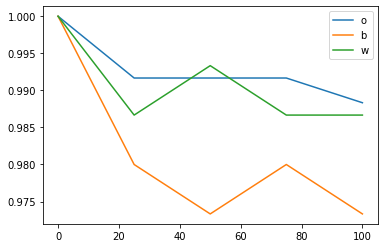

In [217]:
plt.plot([0, 25, 50, 75, 100], os_r2, label="o")
plt.plot([0, 25, 50, 75, 100], bs_r2, label="b")
plt.plot([0, 25, 50, 75, 100], ws_r2, label="w")
plt.legend()

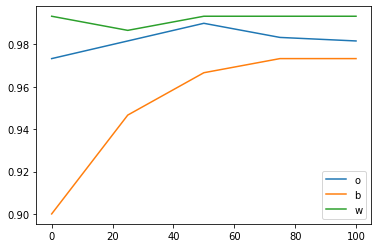

In [218]:
plt.plot([0, 25, 50, 75, 100], os_r, label="o")
plt.plot([0, 25, 50, 75, 100], bs_r, label="b")
plt.plot([0, 25, 50, 75, 100], ws_r, label="w")
plt.legend()

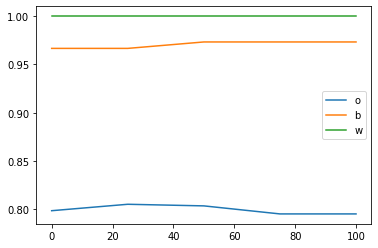

In [220]:
plt.plot([0, 25, 50, 75, 100], os_l, label="o")
plt.plot([0, 25, 50, 75, 100], bs_l, label="b")
plt.plot([0, 25, 50, 75, 100], ws_l, label="w")
plt.legend()

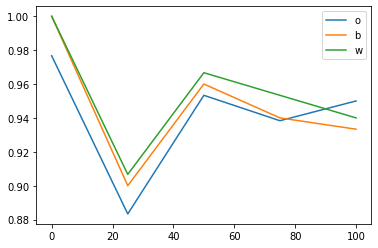

In [219]:
plt.plot([0, 25, 50, 75, 100], os_l2, label="o")
plt.plot([0, 25, 50, 75, 100], bs_l2, label="b")
plt.plot([0, 25, 50, 75, 100], ws_l2, label="w")
plt.legend()

## Visualize Top Features

In [59]:
# Extract all possible features
feature_coord, feature_type = \
    haar_like_feature_coord(width=36, height=36,
                            feature_type=feature_types)

In [221]:
def gettop(fnames, rf):
    ims = getimgs(fnames)
    fig, axes = plt.subplots(4, 5, figsize=(20,20))
    ims = np.array([cv2.resize(im, (36,36)) for im in ims])
    # Sort features in order of importance and plot the six most significant
    idx_sorted = np.argsort(rf.feature_importances_)[::-1]
    for idx, ax in enumerate(axes.ravel()):
        image = ims[5]
        image = draw_haar_like_feature(image, 0, 0,
                                       ims.shape[2],
                                       ims.shape[1],
                                       [feature_coord[idx_sorted[idx]]])
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])

    fig.suptitle('The most important features')

In [222]:
gettop(face_filenames0, rf0)

TypeError: getimgs() missing 2 required positional arguments: 'nonfaces' and 'n'

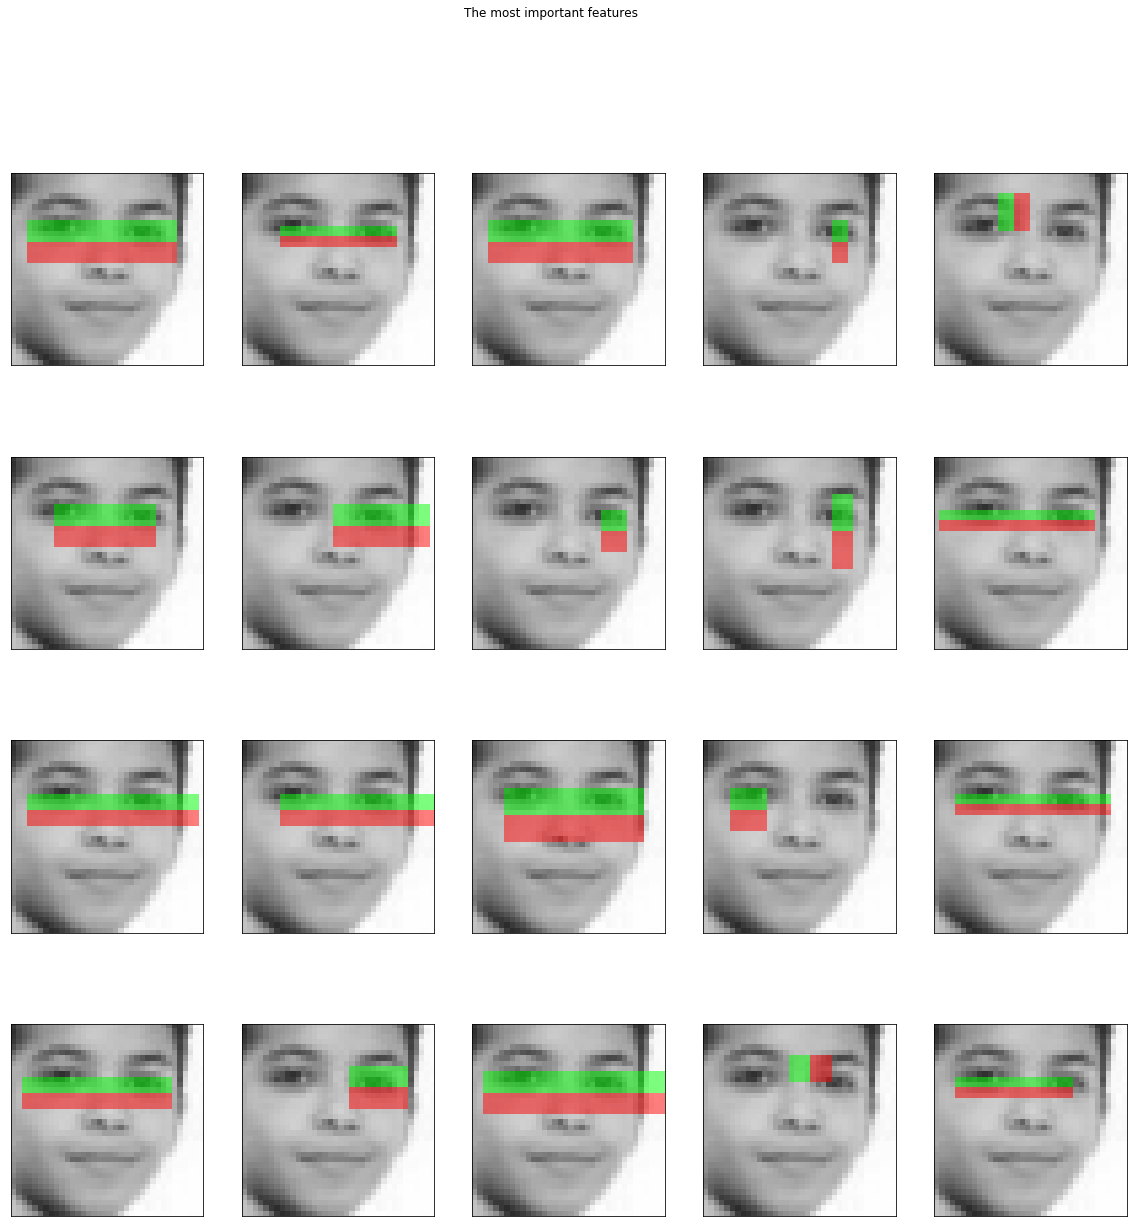

In [68]:
gettop(face_filenames25, rf25)

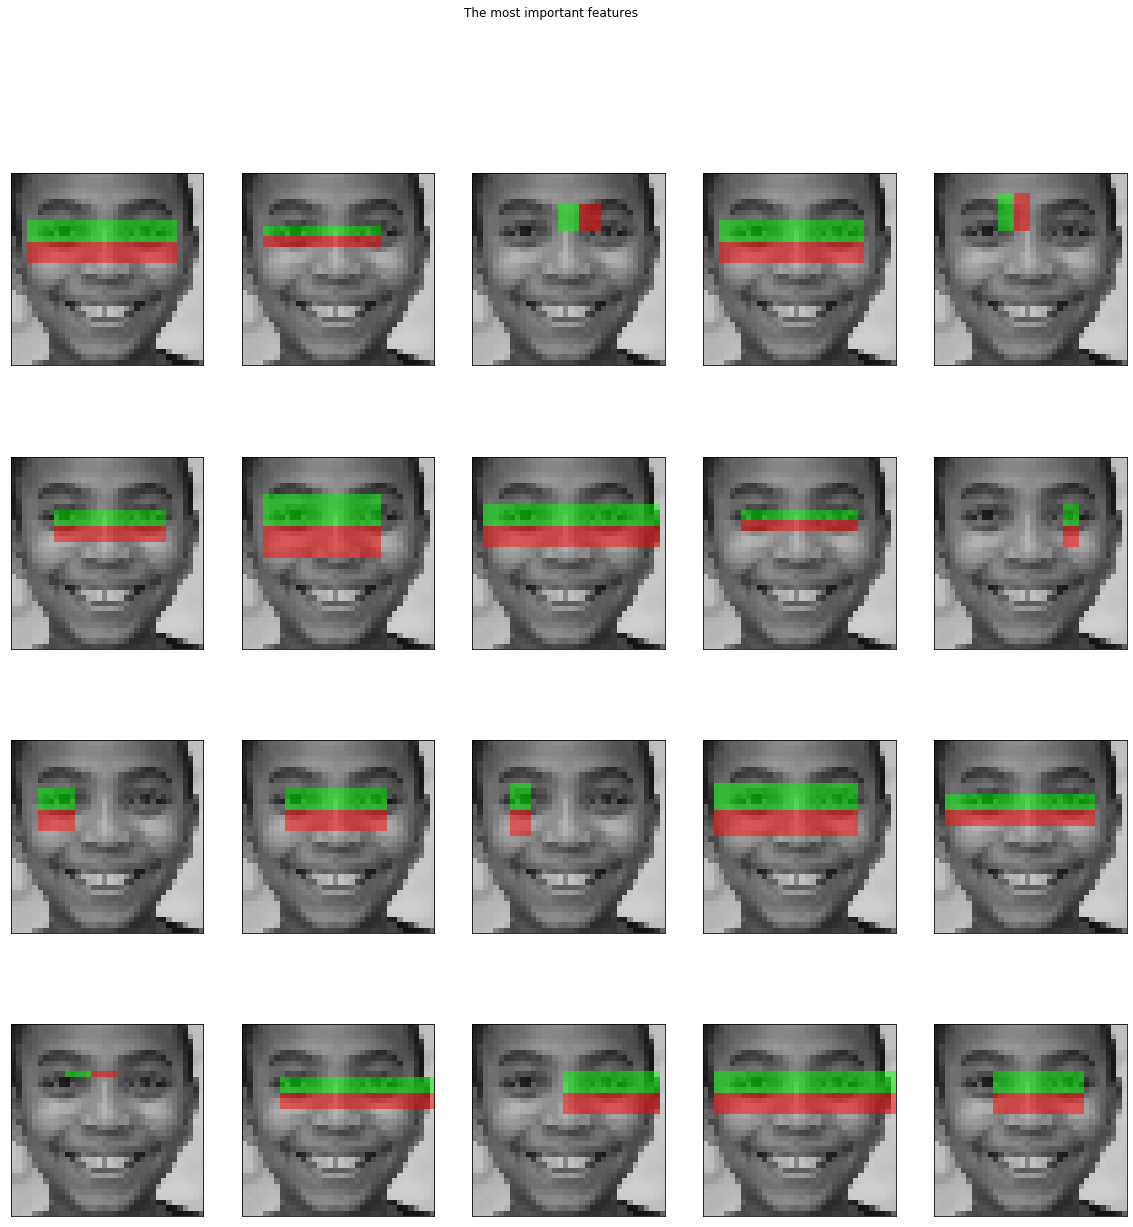

In [69]:
gettop(face_filenames50, rf50)

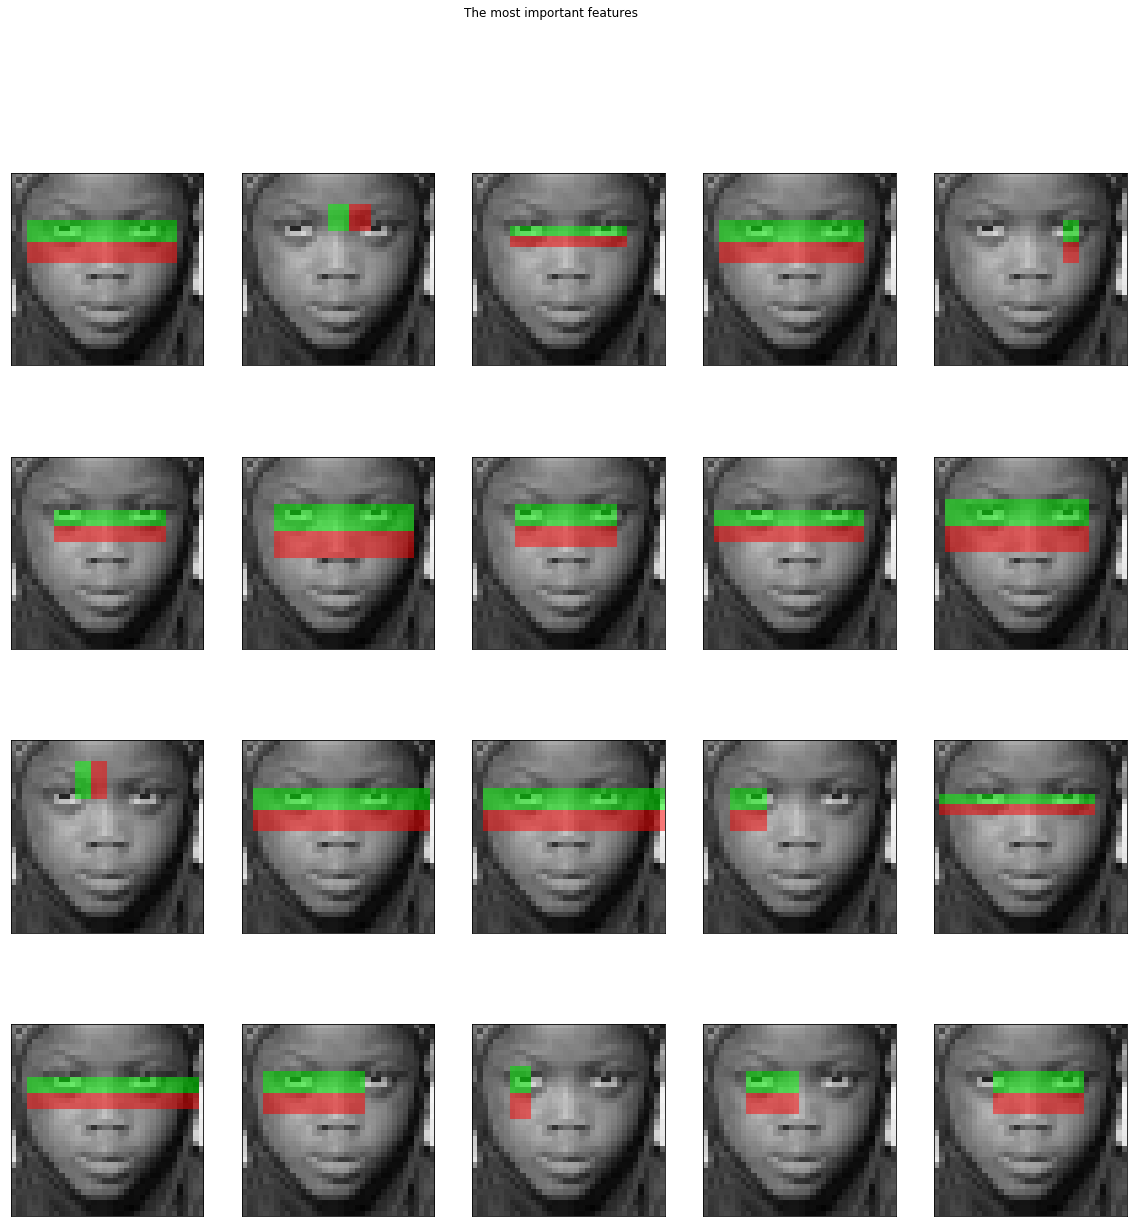

In [70]:
gettop(face_filenames75, rf75)

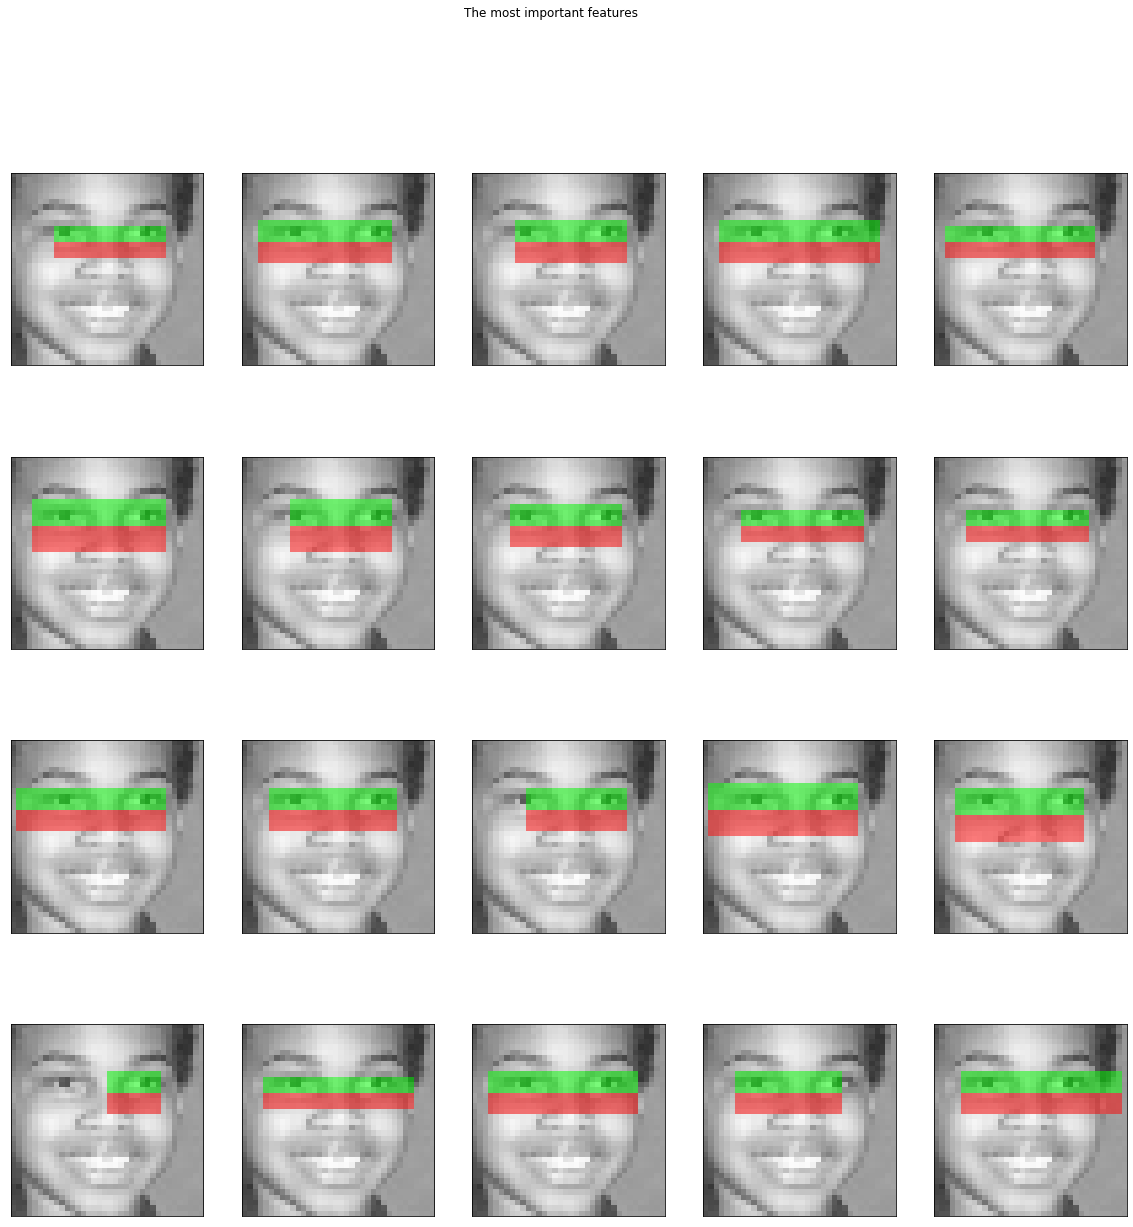

In [71]:
gettop(face_filenames100, rf100)